# Análise Comparativa: Players × Estratégias de Busca

## Vamos rodar Monte Carlo para cada par (Player, Search) e comparar as métricas.

## 1. Cabeçalho e configurações iniciais

In [26]:
%matplotlib inline
import random
import pandas as pd
import matplotlib.pyplot as plt

from main import rodar_simulacao
from search import (
    GreedySearch, 
    DijkstraSearch, 
    AStarSearch, 
    WeightedAStarSearch
)
from player import (
    DefaultPlayer,    
    DoubleBatchPlayer,
    FullBatchPlayer,     
    AdaptivePlayer,
    ClusterAdaptivePlayer,
    RechargerPlayer,
    OptimalPlayer,
    OptimalRechargerPlayer
)

## 2. Definição de listas de players e buscas

In [27]:
SEARCH_ALGORITHMS = [    
    GreedySearch,
    DijkstraSearch,
    AStarSearch,
    WeightedAStarSearch,
]

PLAYERS = [
    DefaultPlayer,    
    DoubleBatchPlayer,
    FullBatchPlayer,
    AdaptivePlayer,
    ClusterAdaptivePlayer,
    RechargerPlayer,
    OptimalPlayer,
    OptimalRechargerPlayer,
]

## 3. Funções de Monte Carlo e sumarização

In [28]:
def monte_carlo(player_cls, search_cls, seeds):
    """
    Executa n simulações Monte Carlo para um par (player, search).
    Retorna uma lista de dicionários com os resultados.
    """
    results = []
    for seed in seeds:
        r = rodar_simulacao(seed, player_cls, search_cls)
        r["player"] = player_cls.__name__
        r["search"] = search_cls.__name__
        r["seed"]   = seed
        results.append(r)
    return results

def summarize(df: pd.DataFrame) -> pd.DataFrame:
    """
    Agrupa por (player, search) e calcula estatísticas:
    passos, score, entregas, bateria, percentuais, tempo em ms.
    """
    summary = (
        df.groupby(["player","search"])
        .agg(
            mean_steps      = ("passos",  "mean"),
            std_steps       = ("passos",  "std"),
            mean_score      = ("score",   "mean"),
            std_score       = ("score",   "std"),
            mean_deliveries = ("entregas","mean"),
            std_deliveries  = ("entregas","std"),
            mean_battery    = ("bateria", "mean"),
            std_battery     = ("bateria", "std"),
            pct_score_neg   = ("score",   lambda s: (s < 0).mean() * 100),
            pct_batt_neg    = ("negative_battery_count", lambda s: (s > 0).mean() * 100),
            mean_search_ms  = ("avg_search_time", lambda s: s.mean() * 1000),
            std_search_ms   = ("avg_search_time", lambda s: s.std() * 1000),
            mean_time_ms    = ("sim_time", lambda s: s.mean() * 1000),
            std_time_ms     = ("sim_time", lambda s: s.std() * 1000),
        )
        .round(2)
        .reset_index()
    )
    return summary

## 4. Funções de plotagem

In [29]:
def plot_metric(df, metric, title, ylabel):
    pivot = df.pivot(index="player", columns="search", values=metric)
    ax = pivot.plot(kind="bar", figsize=(8,4))
    ax.set_title(title)
    ax.set_xlabel("Player")
    ax.set_ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.legend(title="Busca")
    plt.tight_layout()
    plt.show()

def plot_all(summary):
    plot_metric(summary, "mean_steps",      "Passos Médios",                  "Passos Médios")
    plot_metric(summary, "mean_score",      "Score Médio",                    "Pontos Médios")
    plot_metric(summary, "mean_deliveries", "Entregas Médias",                "Entregas Médias")
    plot_metric(summary, "mean_battery",    "Bateria Média",                  "Carga Média Restante")
    plot_metric(summary, "pct_score_neg",   "% Scores Negativos",             "% Simulações Score < 0")
    plot_metric(summary, "pct_batt_neg",    "% Baterias Negativas",           "% Simulações Bateria Negativa")
    plot_metric(summary, "mean_search_ms",  "Tempo Médio de Busca (ms)",      "ms por Busca")
    plot_metric(summary, "mean_time_ms",    "Tempo Médio por Simulação (ms)", "ms por Simulação")

## 5. Geração de seeds e execução Monte Carlo

In [30]:
# 1) Seeds fixas para reprodutibilidade
num_sim = 300
random.seed(42)
seeds = [random.randint(0, 100_000) for _ in range(num_sim)]

# 2) Executa Monte Carlo
all_results = []
for player in PLAYERS:
    for search in SEARCH_ALGORITHMS:
        print(f"Executando Monte Carlo para --- {player.__name__} + {search.__name__}")
        all_results.extend(monte_carlo(player, search, seeds))

# 3) Converte para DataFrame
df = pd.DataFrame(all_results)

Executando Monte Carlo para --- DefaultPlayer + GreedySearch
Executando Monte Carlo para --- DefaultPlayer + DijkstraSearch
Executando Monte Carlo para --- DefaultPlayer + AStarSearch
Executando Monte Carlo para --- DefaultPlayer + WeightedAStarSearch
Executando Monte Carlo para --- DoubleBatchPlayer + GreedySearch
Executando Monte Carlo para --- DoubleBatchPlayer + DijkstraSearch
Executando Monte Carlo para --- DoubleBatchPlayer + AStarSearch
Executando Monte Carlo para --- DoubleBatchPlayer + WeightedAStarSearch
Executando Monte Carlo para --- FullBatchPlayer + GreedySearch
Executando Monte Carlo para --- FullBatchPlayer + DijkstraSearch
Executando Monte Carlo para --- FullBatchPlayer + AStarSearch
Executando Monte Carlo para --- FullBatchPlayer + WeightedAStarSearch
Executando Monte Carlo para --- AdaptivePlayer + GreedySearch
Executando Monte Carlo para --- AdaptivePlayer + DijkstraSearch
Executando Monte Carlo para --- AdaptivePlayer + AStarSearch
Executando Monte Carlo para --- A

## 6. Sumarização e exibição

In [31]:
# Carregamento dos dados opcional para caso não queira executar a simulação
# summary = pd.read_csv("player_search_comparison.csv")
summary = summarize(df)
display(summary)

,player,search,mean_steps,std_steps,mean_score,std_score,mean_deliveries,std_deliveries,mean_battery,std_battery,pct_score_neg,pct_batt_neg,mean_search_ms,std_search_ms,mean_time_ms,std_time_ms
0,AdaptivePlayer,AStarSearch,103.65,20.89,-25.01,103.74,4.00,0.06,-27.70,25.40,53.67,89.67,0.10,0.06,8.10,3.49
1,AdaptivePlayer,DijkstraSearch,103.65,20.89,-24.91,103.84,4.00,0.06,-27.49,25.80,53.67,89.67,0.33,0.10,9.28,3.46
2,AdaptivePlayer,GreedySearch,108.25,23.80,-42.68,115.50,4.00,0.06,-30.17,28.32,58.67,91.67,0.05,0.02,6.89,2.95
3,AdaptivePlayer,WeightedAStarSearch,104.53,21.50,-28.25,106.61,4.00,0.06,-28.07,26.19,55.00,89.33,0.05,0.03,6.79,2.88
4,ClusterAdaptivePlayer,AStarSearch,104.46,20.13,-30.34,101.29,4.00,0.06,-29.37,24.40,56.00,91.33,0.11,0.06,8.88,3.49
5,ClusterAdaptivePlayer,DijkstraSearch,104.46,20.13,-30.25,101.41,4.00,0.06,-29.16,24.83,56.00,91.33,0.36,0.13,10.06,3.46
6,ClusterAdaptivePlayer,GreedySearch,109.10,22.81,-48.37,112.25,4.00,0.06,-31.32,27.95,62.00,93.67,0.06,0.03,7.64,3.23
7,ClusterAdaptivePlayer,WeightedAStarSearch,105.34,20.64,-34.14,103.79,4.00,0.06,-29.55,25.63,58.33,91.33,0.06,0.04,7.99,3.43
8,DefaultPlayer,AStarSearch,115.60,26.86,-82.42,134.66,3.99,0.23,-37.44,33.75,67.33,93.67,0.11,0.09,1.03,0.49
9,DefaultPlayer,DijkstraSearch,115.60,26.86,-82.20,134.52,3.99,0.23,-37.44,33.75,67.33,93.67,0.40,0.12,3.29,0.95


## 7. Salvando CSV

In [32]:
summary.to_csv("player_search_comparison.csv", index=False)
print("Resumo salvo em player_search_comparison.csv")

Resumo salvo em player_search_comparison.csv


## 8. Plots finais

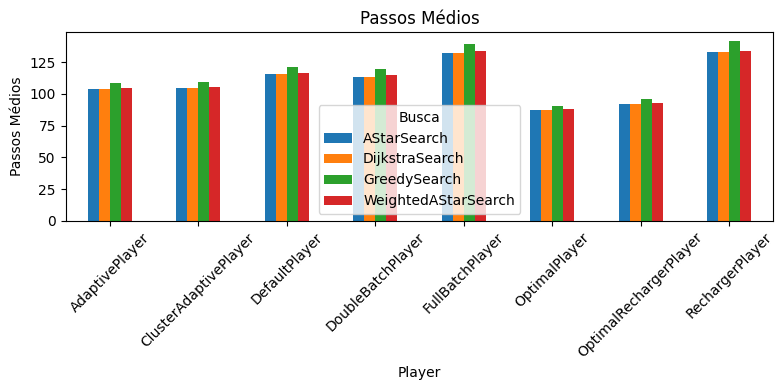

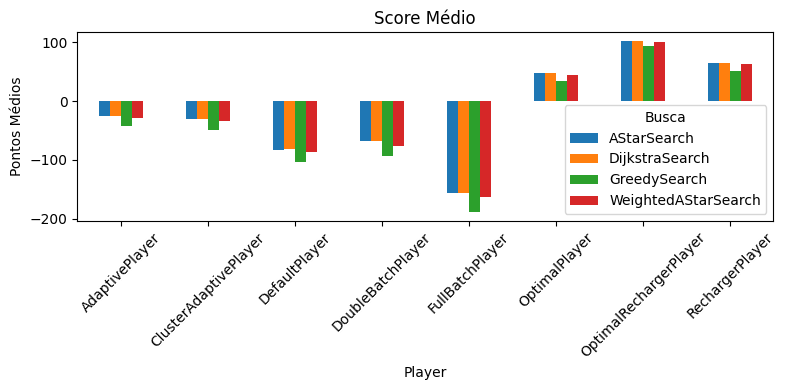

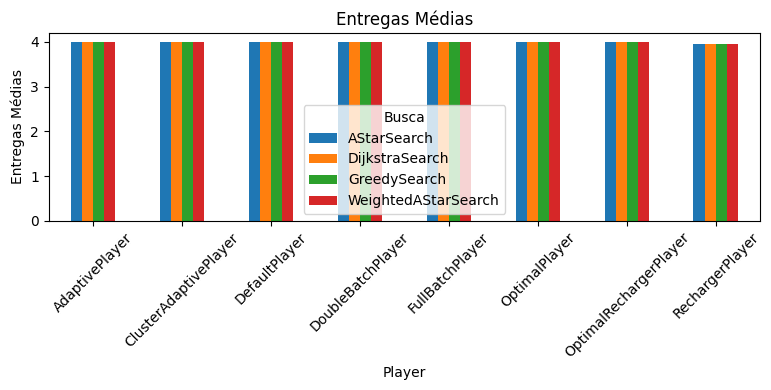

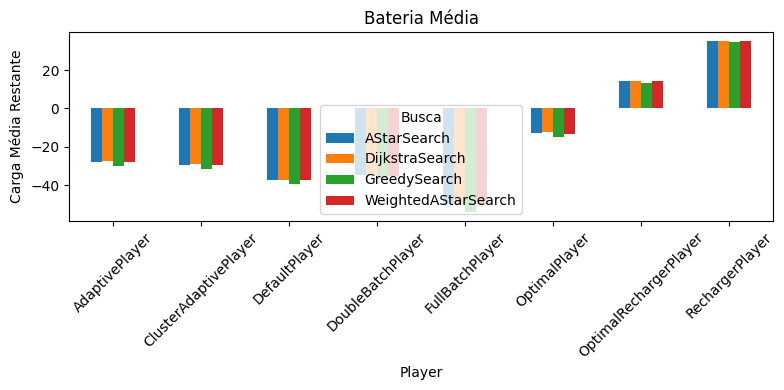

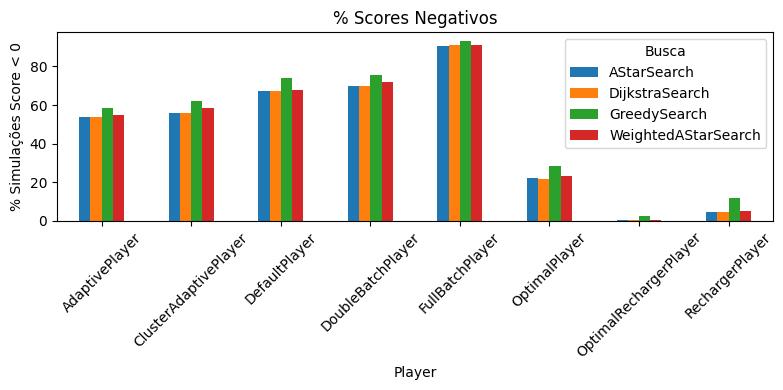

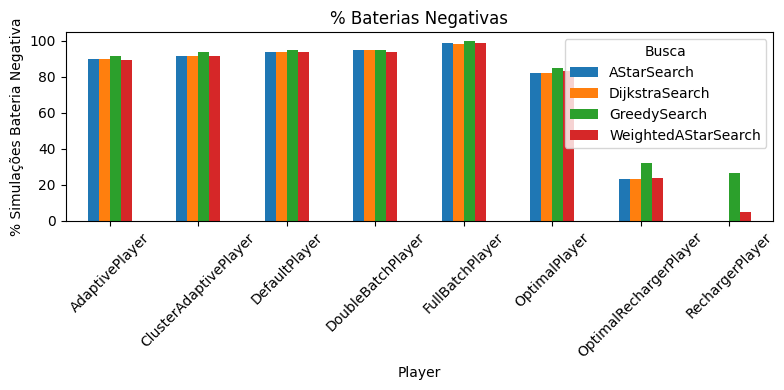

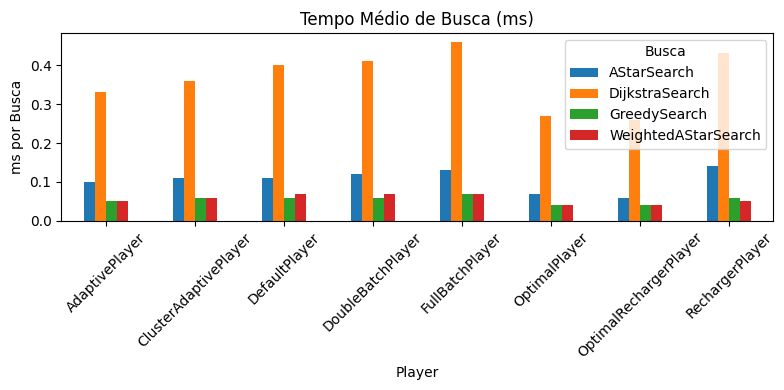

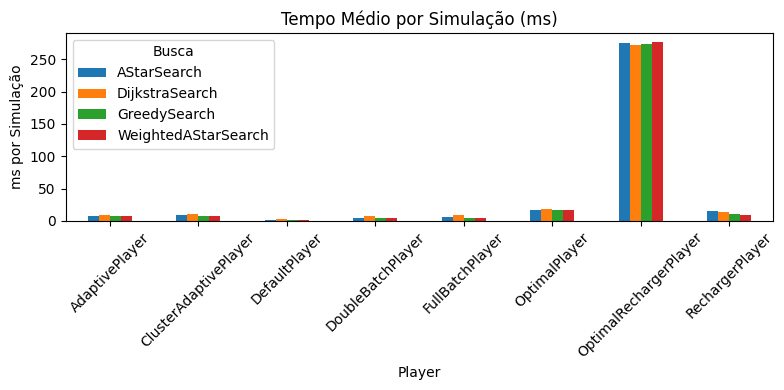

In [33]:
plot_all(summary)

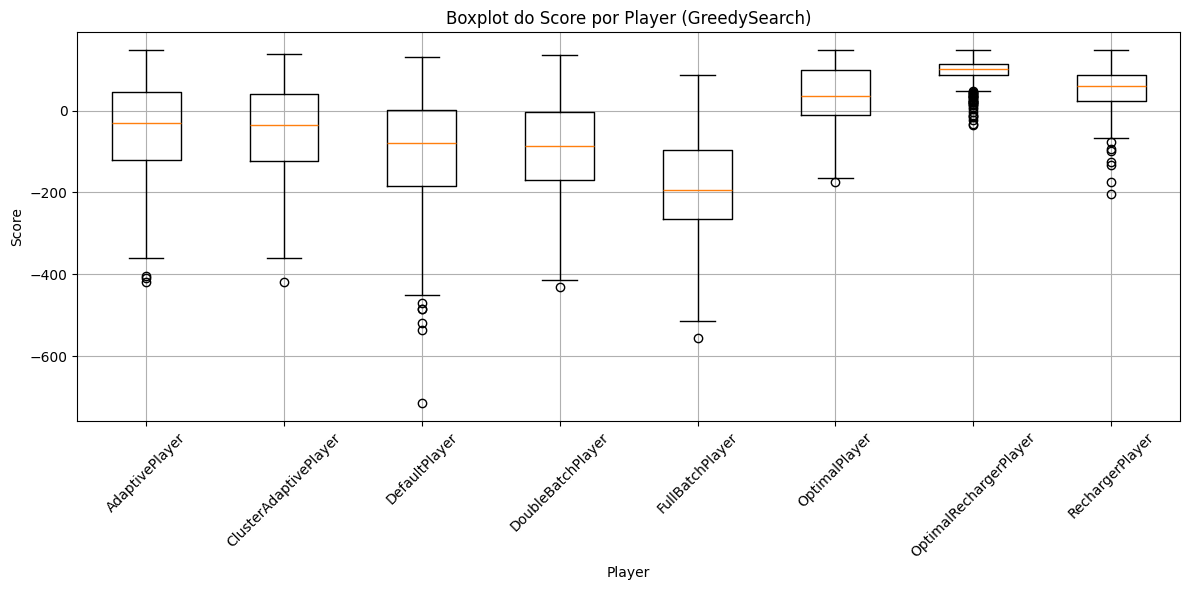

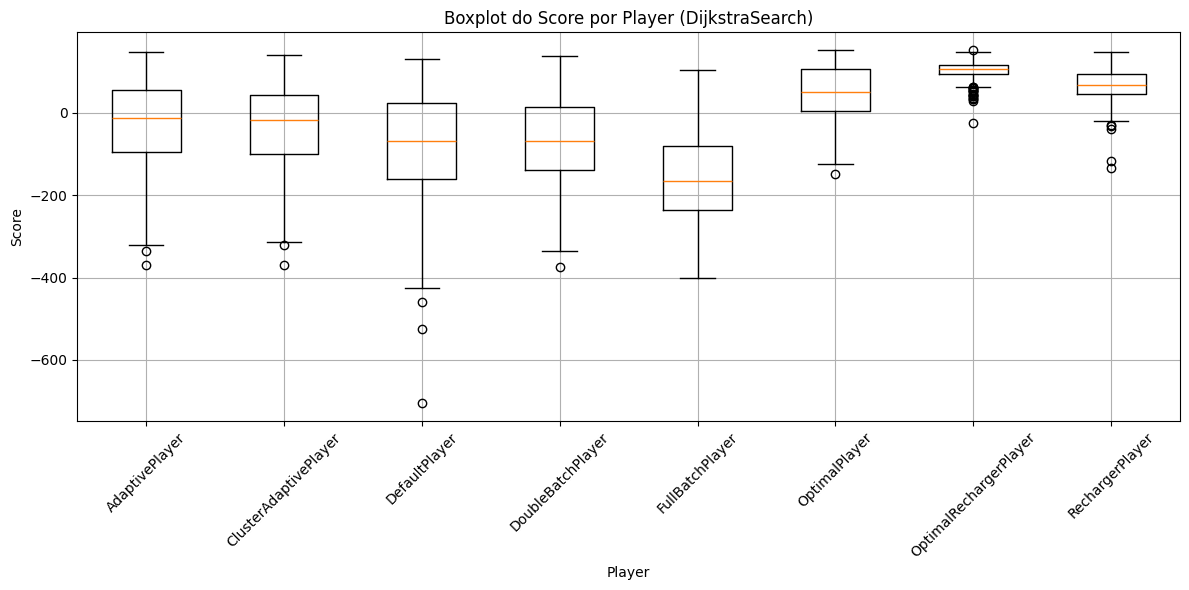

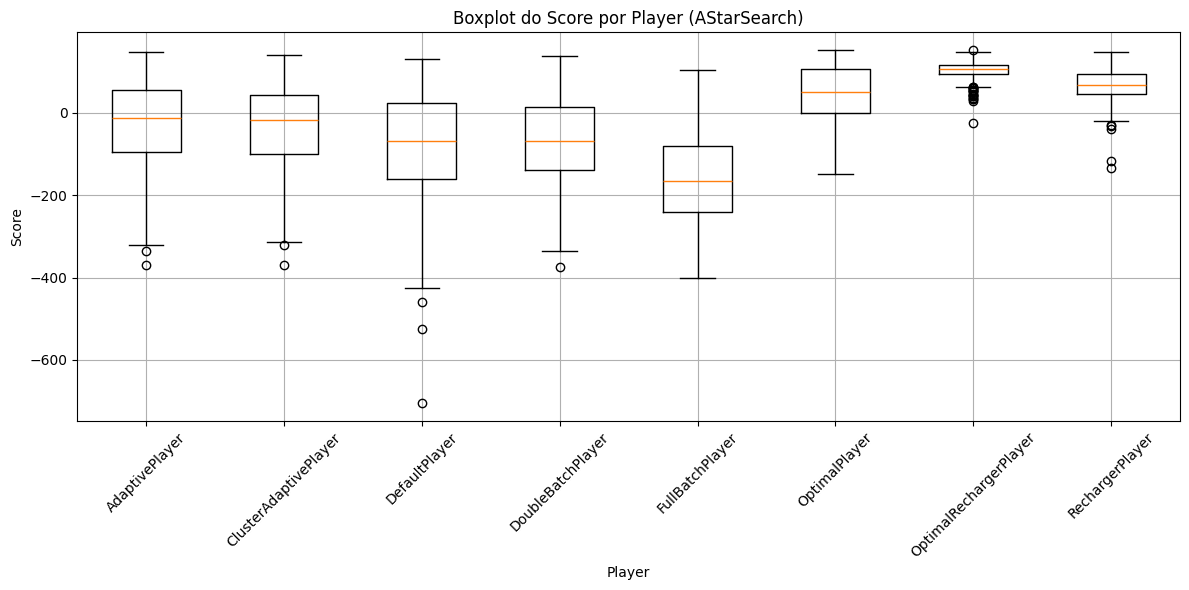

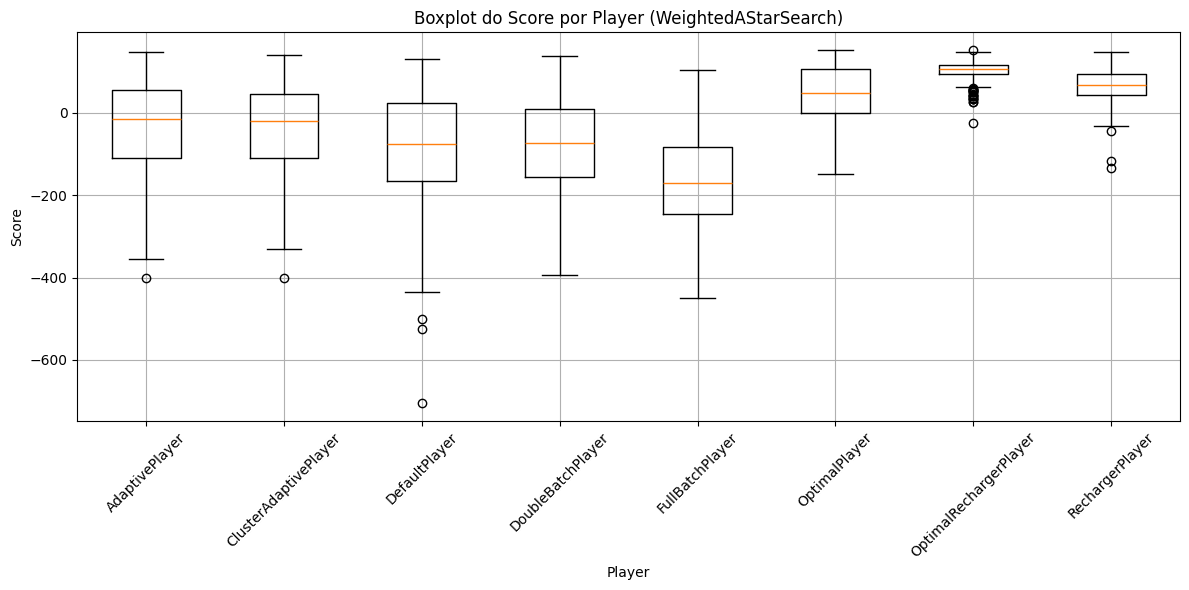

In [38]:
for search_name in [alg.__name__ for alg in SEARCH_ALGORITHMS]:
    players_sorted = sorted(df["player"].unique())
    df_search = df[df["search"] == search_name]
    plt.figure(figsize=(12, 6))
    plt.boxplot(
        [df_search[df_search["player"] == player]["score"] for player in players_sorted],
        labels=players_sorted
    )
    plt.title(f"Boxplot do Score por Player ({search_name})")
    plt.xlabel("Player")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()
